In [ ]:
from google.colab import files
files.upload()

Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"samahassan13","key":"d3b8520d9c664ac21efe6078e3a163db"}'}

In [ ]:
import os
os.makedirs('/root/.kaggle', exist_ok=True)

!mv /content/kaggle.json /root/.kaggle/kaggle.json

# Give permissions
!chmod 600 /root/.kaggle/kaggle.json


In [2]:
import kaggle
kaggle.api.authenticate()
kaggle.api.dataset_download_files(
    'gannayasser/arabic-alphabets-sign-language-dataset-arasl',
    path='.',
    unzip=True
)

Dataset URL: https://www.kaggle.com/datasets/gannayasser/arabic-alphabets-sign-language-dataset-arasl


In [ ]:
import os
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='librosa')

import numpy as np
import seaborn as sns
import shutil
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import pickle as plk

In [ ]:
ROOT = '/content/ArASL_Database_54K_Final/ArASL_Database_54K_Final'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.2 + 0.1,
    subset='training',
    seed=42
)

class_names = train_ds_raw.class_names
NUM_CLASSES = len(train_ds_raw.class_names)



val_test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    ROOT,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    validation_split=0.3,
    subset='validation',
    seed=42
)

val_batches = int(len(val_test_ds_raw) * 0.5)
val_ds_raw = val_test_ds_raw.take(val_batches)
test_ds_raw = val_test_ds_raw.skip(val_batches)

# Prefetch for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds_raw.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds_raw.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds_raw.prefetch(buffer_size=AUTOTUNE)


Found 54049 files belonging to 32 classes.
Using 37835 files for training.
Found 54049 files belonging to 32 classes.
Using 16214 files for validation.


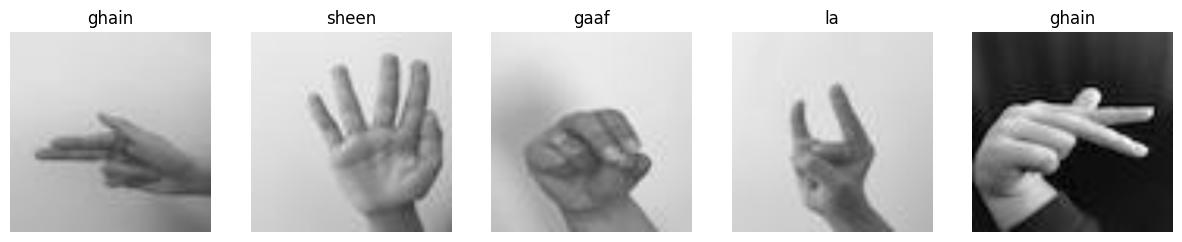

In [16]:
images, labels = next(iter(train_ds))


num_to_show = 5

plt.figure(figsize=(15,5))
for i in range(num_to_show):
    plt.subplot(1, num_to_show, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i].numpy())
    plt.title(class_names[label_index])
    plt.axis('off')
plt.show()

In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_2         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_1     │ (None, 224, 224,  │          7 │ rescaling_2[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_3         │ (None, 224, 224,  │          0 │ normalization_1[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_3[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,090,563 (15.60 MB)

 Trainable params: 40,992 (160.12 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 92s 60ms/step - accuracy: 0.6191 - loss: 1.5406 - val_accuracy: 0.9176 - val_loss: 0.4051
Epoch 2/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 55s 46ms/step - accuracy: 0.8933 - loss: 0.4373 - val_accuracy: 0.9481 - val_loss: 0.2555
Epoch 3/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.9204 - loss: 0.3156 - val_accuracy: 0.9608 - val_loss: 0.1891
Epoch 4/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.9357 - loss: 0.2574 - val_accuracy: 0.9696 - val_loss: 0.1558
Epoch 5/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.9397 - loss: 0.2249 - val_accuracy: 0.9708 - val_loss: 0.1378
Epoch 6/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 52s 44ms/step - accuracy: 0.9462 - loss: 0.2028 - val_accuracy: 0.9731 - val_loss: 0.1227
Epoch 7/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 53s 45ms/step - accuracy: 0.9488 - loss: 0.1853 - val_accuracy: 0.9757 - val_loss: 0.1138
Epoch 8/10
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 53s 44ms/step - accuracy: 0.9510 -

In [ ]:
base_model.trainable = True
model.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history_ft = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=5
)


Epoch 1/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 276s 174ms/step - accuracy: 0.4903 - loss: 2.0220 - val_accuracy: 0.9002 - val_loss: 2.0271
Epoch 2/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 183s 138ms/step - accuracy: 0.8350 - loss: 0.5035 - val_accuracy: 0.9569 - val_loss: 3.7585
Epoch 3/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 163s 138ms/step - accuracy: 0.9099 - loss: 0.2747 - val_accuracy: 0.9708 - val_loss: 1.8219
Epoch 4/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 163s 138ms/step - accuracy: 0.9388 - loss: 0.1869 - val_accuracy: 0.9775 - val_loss: 0.1778
Epoch 5/5
1183/1183 ━━━━━━━━━━━━━━━━━━━━ 202s 138ms/step - accuracy: 0.9603 - loss: 0.1299 - val_accuracy: 0.9813 - val_loss: 0.1034


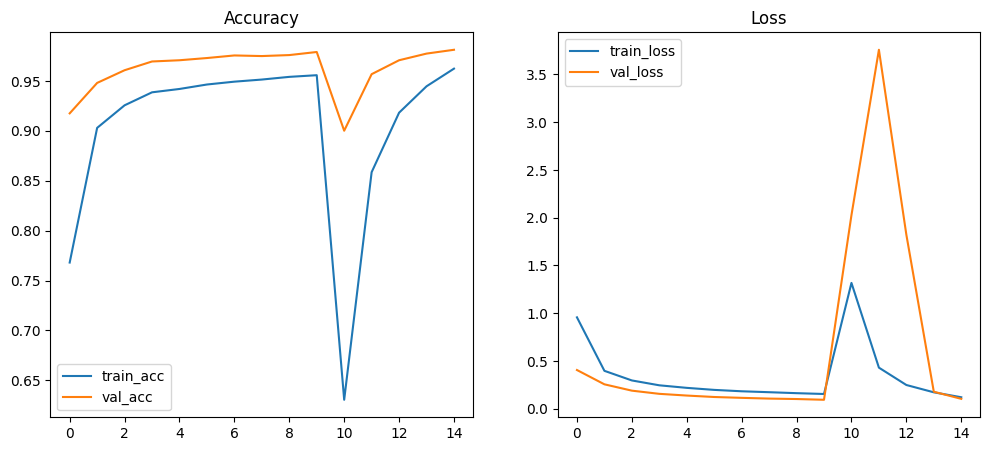

In [ ]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'] + history_ft.history['accuracy'], label='train_acc')
plt.plot(history.history['val_accuracy'] + history_ft.history['val_accuracy'], label='val_acc')
plt.title('Accuracy')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'] + history_ft.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'] + history_ft.history['val_loss'], label='val_loss')
plt.title('Loss')
plt.legend()

plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc*100:.2f}%")

254/254 ━━━━━━━━━━━━━━━━━━━━ 14s 37ms/step - accuracy: 0.9829 - loss: 0.0585
Test Accuracy: 98.35%


In [ ]:
model.save(r"C:\ARsl_\arsl_efficientnetb0_model.keras")
